## Классификация текстов

<img src="http://vtm.e15.cz/files/imagecache/dust_filerenderer_big/upload/aktuality/ilustra_n__foto_4d0a03cf0b.jpg" alt="Robot reads book" style="width: 300px; float: right;"/>

Зачем?
* Определение тональности обращения
* Определение авторства текста
* Определение спама
* Определение намерения обращения
* Определение категорий (тегов)

Варианты подходов которые мы рассмотрим:
1. TF-IDF + Logit
1. Average W2V Vector
1. N-Char + CNN

### Подгоотовка данных

Папка с данными: https://goo.gl/xJeD6V 
- lenta_10000.csv - 7 классов, 10000 новостей для каждого класса, всего 70к. новостей
- lenta_1000.csv - 7 классов, 1000 новостей для каждого класса, всего 7к. новостей
- lenta_1000_lem.csv - 7 классов, 1000 новостей для каждого класса, всего 7к. новостей + лемматизированный текст

Список классов:
- world
- media
- life
- sport
- science
- economics
- culture

#### Импортируем необходимые библиотеки для работы

In [1]:
import numpy as np # Поддержка многомерных массивов, высокоуровневых математических функций для работы с многомерными массивами
import pandas as pd # Библиотека для обработки и анализа данных
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Функции для кодирования значений
from sklearn.model_selection import train_test_split # Функция для разбиения данных на тренировочную выборку и тестовую
from matplotlib import pyplot as plt # Библиотека для визуализации данных

In [2]:
np.random.seed(42) # Устанавливаем seed для повторяемости результатов

#### Читаем данные

In [3]:
# df = pd.read_csv('lenta_1000.csv', index_col=0, dtype ={'text': str, 'tag': str, 'title': str})
df = pd.read_csv('lenta_1000_lem.csv', index_col=0, dtype ={'text': str, 'tag': str, 'title': str, 'lem_text': str})

# Приводим столбцы к нужному типу данных
df['text'] = df['text'].apply(str)
df['tag'] = df['tag'].apply(str)
df['title'] = df['title'].apply(str)
df['lem_text'] = df['lem_text'].apply(str)

In [4]:
df.head()

,title,text,tag,lem_text
0,На севере Франции из-за авиабомбы эвакуировали...,Французские власти срочно эвакуировали 1500 че...,world,французский_ADJF власть_NOUN срочно_ADVB эваку...
1,Пилоты Lufthansa приостановили забастовку.,Пилоты немецкой авиакомпании Lufthansa приняли...,world,пилот_NOUN немецкий_ADJF авиакомпания_NOUN luf...
2,В премьер-министра Турции метнули ботинок.,"Премьер-министр Турции Реджеп Тайип Эрдоган, н...",world,премьер-министр_NOUN турция_NOUN реджеп_NOUN т...
3,Эксперты отсоветовали бундесверу приобретать н...,Эксперты сухопутных сил бундесвера раскритиков...,world,эксперт_NOUN сухопутный_ADJF сила_NOUN бундесв...
4,В Италии разгромили международную банду наркот...,"Итальянская полиция в понедельник, 22 февраля,...",world,итальянский_ADJF полиция_NOUN понедельник_NOUN...


#### Смотрим сколько у нас примеров для каждого класса

In [10]:
df.tag.value_counts()

world        1000
media        1000
life         1000
sport        1000
science      1000
economics    1000
culture      1000
Name: tag, dtype: int64

#### Получаем токены из текста

Для чего?

- Нужно разбить текст на слова
- Нужно удалить пунктуацию
- Нужно удалить стоп слова

Текст: "Тут очень большой и очень, очень крутой текст который нам нужно разбить на токены." <br/>
Токены: "тут", "очень", "большой", "очень", "очень", "крутой", "текст", "который", "нужно", "разбить", "токены" 

In [5]:
import nltk
import string
from nltk.corpus import stopwords

# nltk.download('punkt') # Скачать словарь пунктуации
# nltk.download('stopwords') # Скачать словарь стоп слов

# nltk.download() # Скачиваем словари для работы NLTK
# Выполняем в консоле "python -m nltk.downloader all"
 
def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)
 
    #let's delete punctuation symbols
    tokens = [i for i in tokens if ( i not in string.punctuation )]
 
    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
 
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
 
    return tokens

In [6]:
tokenize_me('Тут очень большой и очень, очень крутой текст который нам нужно разбить на токены.')

['Тут',
 'очень',
 'большой',
 'очень',
 'очень',
 'крутой',
 'текст',
 'который',
 'нам',
 'нужно',
 'разбить',
 'токены']

#### Лемматизируем текст

Для чего? <br/>
Нужно избавиться от словоформ, чтобы снизить размерность словарей

In [8]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def text_lemmatizer(text):
    lem_array = []
    for word in tokenize_me(text):
        word_info = morph.parse(word)[0]
        lem_array.append(f'{word_info.normal_form}_{word_info.tag.POS}')
    return ' '.join(lem_array)

In [9]:
text_lemmatizer('Привет всем слушателям конференции! Улыбнитесь если не спите!')

'привет_NOUN весь_ADJF слушатель_NOUN конференция_NOUN улыбнуться_VERB спать_VERB'

#### Лемматизируем весь корпус

In [34]:
# %%time
# df['lem_text'] = df['text'].apply(text_lemmatizer)

Wall time: 5min 1s


In [36]:
# df.to_csv('lenta_1000_lem.csv', encoding='utf-8') # Сохраняем результат

#### Закодируем текстовое описание категории в лейблы

In [16]:
count_tags = len(df.tag.value_counts().index.values)
tags = df.tag.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(tags) 
lables = lableEnc.transform(tags).reshape((count_tags, 1))

def tag_to_lable(tag):
    return lableEnc.transform([tag])[0]

df['y'] = df['tag'].apply(tag_to_lable)

In [18]:
df.sample(n=5)

,title,text,tag,lem_text,y
5020,Из библиотеки Академии наук похищена редкая кн...,Из Библиотеки Академии наук в Петербурге в нов...,culture,из_PREP библиотека_NOUN академия_NOUN наука_NO...,0
1034,Сетевым авторам предложили написать wiki-роман.,Британское издательство Penguin и университет ...,media,британский_ADJF издательство_NOUN penguin_None...,3
2993,АЛРОСа временно ушла с международного рынка ал...,Крупнейшая в России алмазодобывающая компания ...,economics,крупный_ADJF россия_NOUN алмазодобывающий_ADJF...,1
2090,Сербия попросила у МВФ дополнительные два милл...,Правительство Сербии начало переговоры с Между...,economics,правительство_NOUN сербия_NOUN начать_VERB пер...,1
1476,"Сергей Кургинян ушел с телеканала ""Россия 1"".",Политолог Сергей Кургинян больше не будет вест...,media,политолог_NOUN сергей_NOUN кургинян_NOUN вести...,3


### Model №1 TF-IDF + LOGIT

### TF-IDF
TF-IDF - статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции.


$$ tf_{i,j} = \frac{n_{i,j}}{\sum_k n_{k,j}} $$

$$ idf_i = \mbox{log} \frac{|D|}{|{d : t_i \in d}|} $$

$$ tfidf_{i,j} = tf_{i,j} * idf_{i}$$

пример с картинкой

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [20]:
%%time
tfidf_vectorizer = TfidfVectorizer(lowercase=True, max_features=10000)
# vectors = tfidf_vectorizer.fit_transform(df['title'].values)
# vectors = tfidf_vectorizer.fit_transform(df['text'].values)
vectors = tfidf_vectorizer.fit_transform(df['lem_text'].values)

Wall time: 1.62 s


In [21]:
X_train, X_test, y_train, y_test = train_test_split(vectors, df['y'], test_size=0.2, random_state=42)

In [26]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=42, multi_class='multinomial', solver='saga')
logit.fit(X_train, y_train)

Wall time: 1.3 s


In [27]:
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred, target_names=lableEnc.classes_)) # Acc

             precision    recall  f1-score   support

    culture       0.88      0.87      0.87       211
  economics       0.89      0.93      0.91       178
       life       0.72      0.79      0.75       186
      media       0.88      0.81      0.84       224
    science       0.88      0.88      0.88       183
      sport       0.98      0.95      0.96       215
      world       0.83      0.82      0.83       203

avg / total       0.87      0.86      0.86      1400



#### Интерпретируем модель

In [29]:
id2word_tfidf = {y:x for x, y in tfidf_vectorizer.vocabulary_.items()}

In [46]:
tag_id_for_impotence = 5
dict_word_weight = {id2word_tfidf[index]:value for index, value in enumerate(logit.coef_[tag_id_for_impotence])}
sorted(dict_word_weight.items(), key=lambda x: x[1], reverse=True)[:10]

[('матч_noun', 4.6970420424323045),
 ('команда_noun', 3.2893632362658325),
 ('чемпионат_noun', 3.1903224167516551),
 ('клуб_noun', 3.1688124304143965),
 ('сборный_adjf', 3.1510016408531225),
 ('тренер_noun', 2.9493814253653774),
 ('турнир_noun', 2.8972923974308427),
 ('чемпион_noun', 2.7343026224013229),
 ('футболист_noun', 2.3641815672194602),
 ('спортсмен_noun', 2.3491643868024239)]

In [51]:
my_news = text_lemmatizer('чемпионат мира по футболу скоро начнется')
print('Текст новости:', my_news)
query_vector = tfidf_vectorizer.transform([my_news])
lable = logit.predict(query_vector)
print('Категория:', lableEnc.inverse_transform(lable)[0])

Текст новости: чемпионат_NOUN мир_NOUN футбол_NOUN скоро_ADVB начаться_VERB
Категория: sport


### Average Word2Vec
Тут тоже рассказики
Рассказать идею

In [2]:
# !pip install gensim

In [52]:
import gensim

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


Придумать пример где TF-IDF плох и показать как хорош W2V

In [107]:
def get_average_w2v_vectors(w2v_model, train_set, tfidf_vectorizer=None):
    '''get movies avarage w2v vectors'''
    text_vectors = []
    for text in train_set:
        words = text.split()
        word_vectors = []
        for word in words:
            if (word in w2v_model):
                word_vector = w2v_model[word]
                if tfidf_vectorizer:
                    word_idf = vectorizer.idf_[vectorizer.vocabulary_[movie_word]]
                    word_vector = word_vector  * word_idf
                word_vectors.append(word_vector)
        text_vectors.append(np.average(word_vectors, axis=0))
    return np.array(text_vectors)

In [69]:
def transform(word2vec, X):
        return np.array([np.mean([word2vec[word] for word in sent.split() if word in word2vec] or 
                                 [np.zeros(w2v_model.vector_size)], axis=0)
                         for sent in X])

In [44]:
# w2v_model = gensim.models.Word2Vec.load('w2v/movies_w2v_lem_review_with_not.model')

In [55]:
# Готовые модели на http://rusvectores.org/ru/models/
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('news_upos_cbow_300_2_2017.bin.gz', binary=True)

In [56]:
w2v_model.wv.most_similar(['политика_NOUN'])

[('стратегия_NOUN', 0.39227014780044556),
 ('госполитика_NOUN', 0.3522140383720398),
 ('реформа_NOUN', 0.34776410460472107),
 ('развитие_NOUN', 0.34623318910598755),
 ('дкп_NOUN', 0.3374726176261902),
 ('агрополитика_NOUN', 0.329285204410553),
 ('соцполитика_NOUN', 0.31780004501342773),
 ('сотрудничество_NOUN', 0.31736862659454346),
 ('регулирование_NOUN', 0.3144778609275818),
 ('риторика_NOUN', 0.31168729066848755)]

In [71]:
%%time
# w2v_vectors = get_average_w2v_vectors(w2v_model, df['lem_text'])
w2v_vectors = transform(w2v_model, df['lem_text'])

Wall time: 2.35 s


In [74]:
w2v_vectors[:5]

array([[  3.89993587e-03,  -5.92009677e-03,   9.75634321e-05, ...,
         -1.94175784e-02,   1.93597525e-02,   1.42552396e-02],
       [ -2.44142022e-02,   2.51718387e-02,  -1.12227416e-02, ...,
         -8.49262066e-03,   2.14149971e-02,  -1.46490885e-02],
       [  7.38463085e-03,   7.32827582e-04,  -2.43212227e-02, ...,
         -1.50246648e-02,  -5.54042170e-03,   2.09822087e-03],
       [ -9.41815134e-03,  -3.19693983e-02,  -3.52576980e-03, ...,
         -2.17719339e-02,   6.49620825e-03,  -2.67958525e-03],
       [ -2.34256610e-02,  -3.53221956e-04,  -1.40080974e-02, ...,
          1.08224503e-03,  -1.07913800e-02,   1.67869851e-02]])

In [75]:
X_train, X_test, y_train, y_test = train_test_split(w2v_vectors, df['y'], test_size=0.2, random_state=42)

In [76]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=42, multi_class='multinomial', solver='saga')
logit.fit(X_train, y_train)

Wall time: 2.54 s


In [77]:
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred, target_names=lableEnc.classes_))

             precision    recall  f1-score   support

    culture       0.84      0.84      0.84       211
  economics       0.82      0.93      0.87       178
       life       0.69      0.75      0.72       186
      media       0.81      0.68      0.74       224
    science       0.80      0.79      0.80       183
      sport       0.98      0.91      0.94       215
      world       0.76      0.81      0.78       203

avg / total       0.82      0.81      0.81      1400



Почему такие результаты

## Deep Learning for Text Classification

### CNN + CHAR N GRAMS
Тут тоже рассказик
картинки

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

In [79]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, TimeDistributed, Bidirectional
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

НУЖНО НАЙТИ ЗАМЕНУ!

In [88]:
def texts2ngrams(texts, n=3, lowercase=True):
    """ Convert text into character ngrams. """
    vectors = []
    dict_grams = {}
    char_index = 0
    for text in texts:
        if lowercase:
            text = text.lower()
        vector = []
        grams_for_text = ["".join(j) for j in zip(*[text[i:] for i in range(n)])]
        for gram in grams_for_text:
            if gram in dict_grams:
                vector.append(dict_grams[gram])
            else:
                dict_grams[gram] = char_index
                vector.append(char_index)
                char_index += 1
        vectors.append(vector)
    count_grams = len(dict_grams)
    print('Количество уникальных ngrams:', count_grams)
    return vectors, count_grams

In [89]:
def print_plot_mean(x):
    lens = [len(y) for y in x]
    print('Max len:', max(lens))
    plt.plot(lens);

In [91]:
%%time
gram_vectors, count_grams = texts2ngrams(df.lem_text)
print_plot_mean(gram_vectors)

Количество уникальных ngrams: 27994
Max len: 30883
Wall time: 8.5 s


Показать картинку 

In [92]:
X = keras.preprocessing.sequence.pad_sequences(gram_vectors, maxlen=2500)     
y = keras.utils.to_categorical(df['y'], count_tags)

In [93]:
def get_conv_model(embeding_size, num_classes):
    model = Sequential()
    model.add(Embedding(embeding_size, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
%%time
model = get_conv_model(embeding_size=count_grams, num_classes=count_tags)
model.summary()

BATCH_SIZE = 256
EPOCHS = 3
VERBOSE = 1

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=VERBOSE,
                    validation_data=(X_test, y_test)
                    #validation_split=0.1, 
                    #callbacks=[EarlyStopping(monitor='val_loss')]
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         5598800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 256)         153856    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 5,754,455
Trainable params: 5,754,455
Non-trainable params: 0
_________________________________________________________________
Train on 5600 samples, validate on 1400 samples
Epoch 1/3
2816/5600 [==============>...............] - ETA: 387s - loss: 1.9190 - ac

In [135]:
print('Точность модели составляет: {}'.format(model.evaluate(X_test, y_test, batch_size=64, verbose=2)[1] * 100))

Точность модели составляет: 77.57142860548836


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


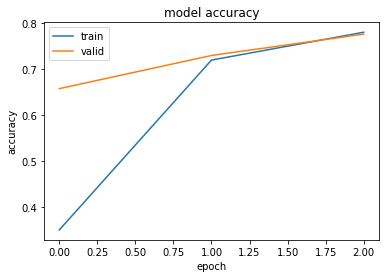

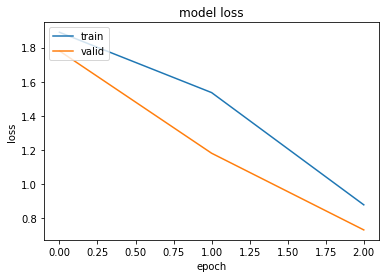

In [136]:
from matplotlib import pyplot as plt
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();

График обучения

Посчитать на ноуте

Результаты